In [5]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import *
import os

import os
from pathlib import Path
import pandas as pd
from datasets import load_dataset  # Assuming this is from the 'datasets' library

import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
from datasets import load_dataset
import warnings

import os
from pathlib import Path
import pandas as pd
from datasets import load_dataset  # Assuming this is from the 'datasets' library
import sys
from pathlib import Path

# Add the parent directory of the notebook to the Python path
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
from datasets import load_dataset
import warnings

import os
from pathlib import Path
import pandas as pd
from datasets import load_dataset  # Assuming this is from the 'datasets' library
import sys
from pathlib import Path

# Add the parent directory of the notebook to the Python path
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))

from funcs.data_read import (
    read_txn_data,  
    read_ob_data,
    load_ob_features,
    load_trx_features,
)

from funcs.preprocess import (
    preprocess_ob_data, 
    preprocess_trx_data,
)

from funcs.features import (
    create_features_order_book,
    create_features_trx,
)

from funcs.utils import (
    filter_extremes,
    deseason_total_volume,
)






### Data Loading

In [6]:
trx_1min_features = load_trx_features("1min")
ob_1min_fatures=load_ob_features(freq="1min")

✅ Loaded TRX features (1min) from:
C:\Users\peter\codes\ml\eth\Komplex\trx_features\trx_features_1min.parquet
Reading 109 files from C:\Users\peter\codes\ml\eth\Komplex\ob_features\1min...
Combined DataFrame for 1min created. Total rows: 155,954


In [7]:
trx_features = deseason_total_volume(trx_1min_features)

Deseasoned total volume column added successfully.


In [8]:
# Merge the two DataFrames on "timestamp_id" ,max diff is 1  min
 
# Ensure both DataFrames have the same timestamp format
trx_1min_features['timestamp_id'] = pd.to_datetime(trx_1min_features['timestamp_id'])
ob_1min_fatures['timestamp_id'] = pd.to_datetime(ob_1min_fatures['timestamp_id'])

# Merge the DataFrames on "timestamp_id" with a tolerance of 2 minutes
merged_df = pd.merge_asof(
    trx_1min_features.sort_values("timestamp_id"),
    ob_1min_fatures.sort_values("timestamp_id"),
    on="timestamp_id",
    direction="nearest",
    tolerance=pd.Timedelta("2min")
)

# Check the result of the merge
print(f"Merged DataFrame created. Total rows: {len(merged_df):,}")


#rename datatime_x to datatime
merged_df.rename(columns={"timestamp_id_x": "timestamp_id"}, inplace=True)
merged_df.rename(columns={"datetime_x": "datetime"}, inplace=True)
print(merged_df)

Merged DataFrame created. Total rows: 168,743
                        timestamp_id                  datetime  first_price  \
0      1970-01-01 00:00:01.527800400 2018-05-31 21:00:00+00:00      7538.34   
1      1970-01-01 00:00:01.527800460 2018-05-31 21:01:00+00:00      7532.43   
2      1970-01-01 00:00:01.527800520 2018-05-31 21:02:00+00:00      7535.01   
3      1970-01-01 00:00:01.527800580 2018-05-31 21:03:00+00:00      7540.19   
4      1970-01-01 00:00:01.527800640 2018-05-31 21:04:00+00:00      7541.00   
...                              ...                       ...          ...   
168738 1970-01-01 00:00:01.538344500 2018-09-30 21:55:00+00:00      6553.46   
168739 1970-01-01 00:00:01.538344560 2018-09-30 21:56:00+00:00      6555.77   
168740 1970-01-01 00:00:01.538344620 2018-09-30 21:57:00+00:00      6555.75   
168741 1970-01-01 00:00:01.538344680 2018-09-30 21:58:00+00:00      6555.00   
168742 1970-01-01 00:00:01.538344740 2018-09-30 21:59:00+00:00      6555.73   

     

### ARMA-GARCH

In [9]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [10]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### I am not sure about the deseasonalization part, it should be done on a separate train set

In [11]:

import pandas as pd
import numpy as np

# Check the length of the series
print("Length of total_volume:", len(trx_features['deseasoned_total_volume'].dropna()))
print("First few values:", trx_features['deseasoned_total_volume'].head())
print("Any NaN values?", trx_features['deseasoned_total_volume'].isnull().sum())

Length of total_volume: 168743
First few values: 0     9.587523
1   -13.736933
2    -7.232277
3   -12.163045
4    -9.543660
Name: deseasoned_total_volume, dtype: float64
Any NaN values? 0


In [12]:
trx_features['deseasoned_total_volume']

0          9.587523
1        -13.736933
2         -7.232277
3        -12.163045
4         -9.543660
            ...    
168738    -5.165274
168739    -4.900593
168740    -6.534749
168741    -6.393844
168742    -3.871799
Name: deseasoned_total_volume, Length: 168743, dtype: float64

In [13]:
trx_features

,timestamp_id,datetime,first_price,last_price,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance,buy_transactions,sell_transactions,transaction_imbalance,deseasoned_total_volume
0,1527800400,2018-05-31 21:00:00+00:00,7538.34,7542.01,7544.79,7531.36,18.203291,0.677437,18.880728,17.525854,12.0,11.0,1.0,9.587523
1,1527800460,2018-05-31 21:01:00+00:00,7532.43,7539.40,7544.69,7530.81,0.218896,0.946981,1.165876,-0.728085,5.0,6.0,-1.0,-13.736933
2,1527800520,2018-05-31 21:02:00+00:00,7535.01,7540.11,7540.11,7535.01,0.021258,0.011077,0.032336,0.010181,3.0,1.0,2.0,-7.232277
3,1527800580,2018-05-31 21:03:00+00:00,7540.19,7540.00,7541.90,7535.01,0.143166,0.001062,0.144229,0.142104,8.0,1.0,7.0,-12.163045
4,1527800640,2018-05-31 21:04:00+00:00,7541.00,7543.32,7543.32,7538.34,2.837166,0.000000,2.837166,2.837166,9.0,0.0,9.0,-9.543660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168738,1538344500,2018-09-30 21:55:00+00:00,6553.46,6554.33,6555.77,6553.44,1.310116,0.000000,1.310116,1.310116,21.0,0.0,21.0,-5.165274
168739,1538344560,2018-09-30 21:56:00+00:00,6555.77,6554.20,6555.77,6554.20,0.134624,0.038058,0.172682,0.096565,2.0,1.0,1.0,-4.900593
168740,1538344620,2018-09-30 21:57:00+00:00,6555.75,6555.78,6555.79,6554.30,1.491747,0.038143,1.529890,1.453603,10.0,1.0,9.0,-6.534749
168741,1538344680,2018-09-30 21:58:00+00:00,6555.00,6555.00,6555.76,6555.00,0.010576,0.924569,0.935145,-0.913993,1.0,8.0,-7.0,-6.393844


In [14]:
trx_features_cleaned = trx_features.dropna().copy()
trx_features_cleaned['total_volume'] = np.log(trx_features_cleaned['total_volume'] + 1e-07)
trx_features_cleaned = trx_features_cleaned.dropna()
trx_features_cleaned["deseasoned_total_volume"].isna().sum()

0

In [15]:
trx_features_cleaned["deseasoned_total_volume"]

0          9.587523
1        -13.736933
2         -7.232277
3        -12.163045
4         -9.543660
            ...    
168738    -5.165274
168739    -4.900593
168740    -6.534749
168741    -6.393844
168742    -3.871799
Name: deseasoned_total_volume, Length: 168743, dtype: float64

### Maybe deseasonalization if not needed

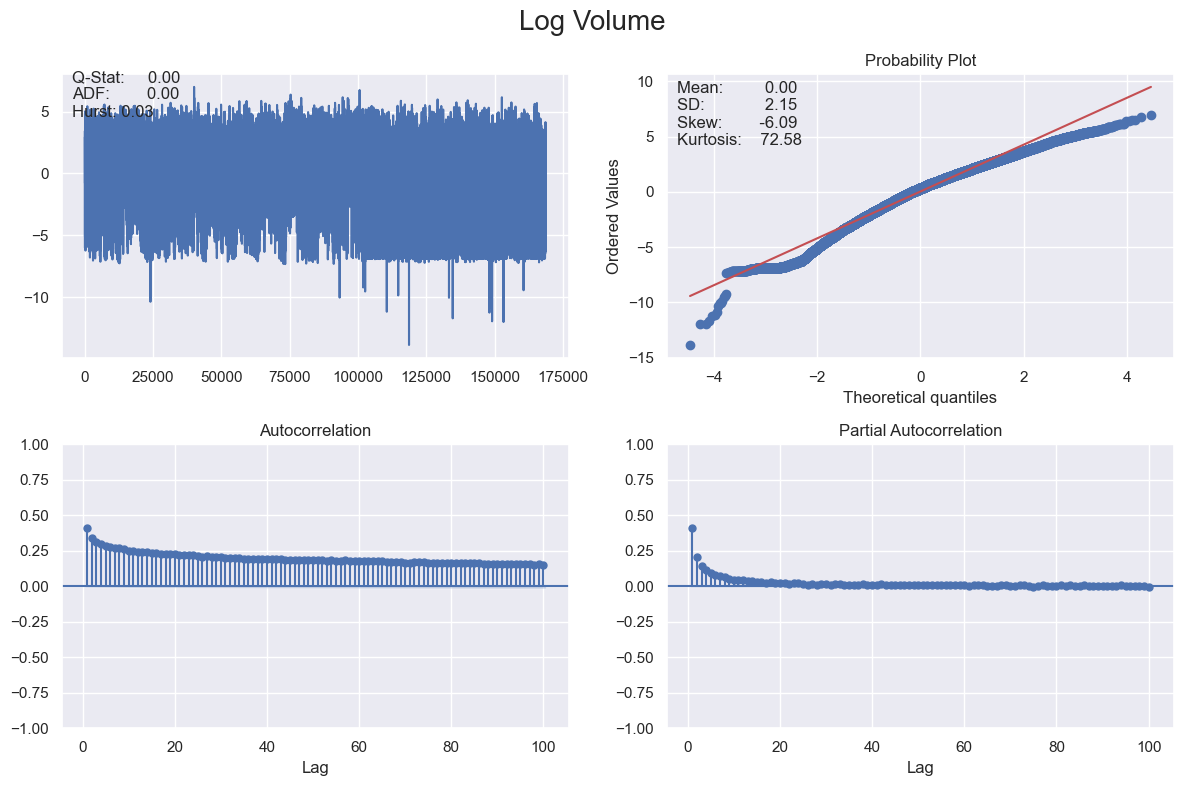

In [16]:
# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(trx_features_cleaned['total_volume'], lags=100, title='Log Volume')

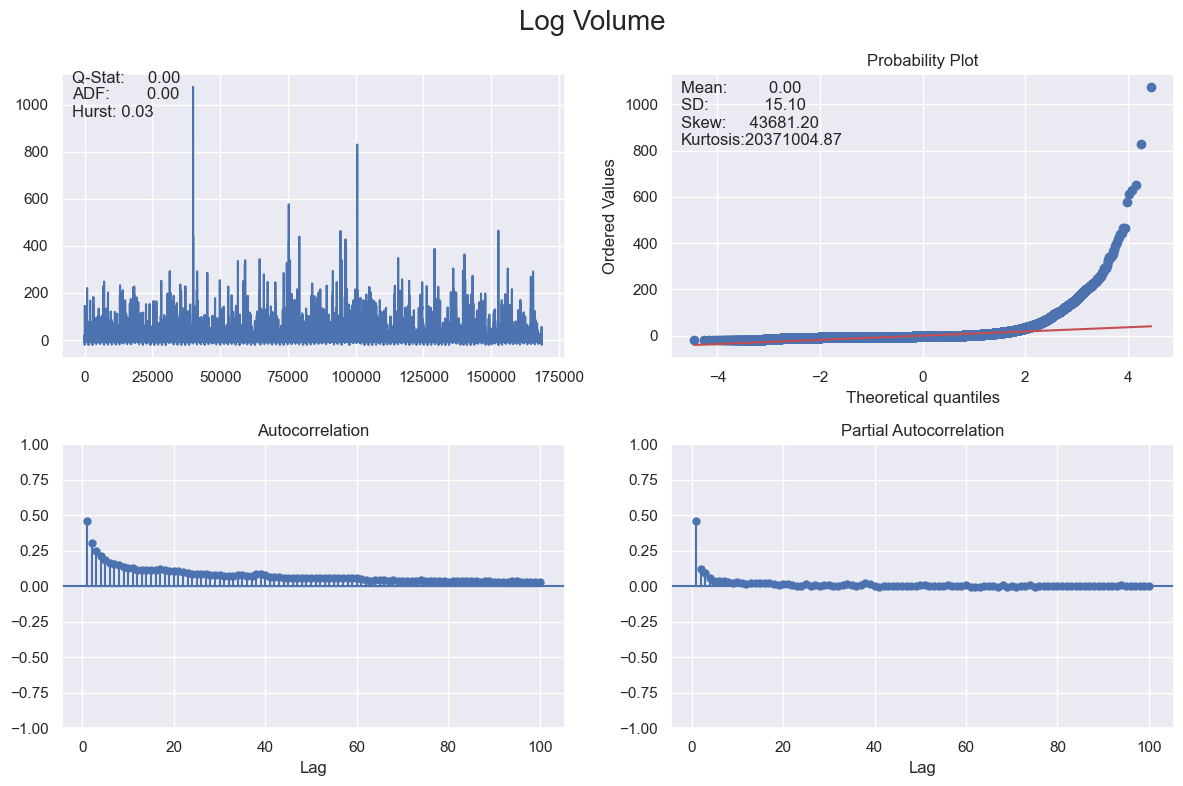

In [17]:

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(trx_features_cleaned['deseasoned_total_volume'], lags=100, title='Log Volume')

In [18]:
# Specify GARCH model assumptions
basic_gm = arch_model(trx_features['deseasoned_total_volume'], p = 1, q = 1,
                      mean = 'ARX', lags=2, vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     44,   Neg. LLF: 128020751.53887431
Iteration:      8,   Func. Count:     77,   Neg. LLF: 622547.8707051439
Iteration:     12,   Func. Count:    106,   Neg. LLF: 1525211.9547011093
Iteration:     16,   Func. Count:    151,   Neg. LLF: 622519.8531610778
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 622519.8533729481
            Iterations: 20
            Function evaluations: 151
            Gradient evaluations: 16


c:\Users\peter\anaconda3\envs\IML2024\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [19]:
print(gm_result.summary())

                              AR - GARCH Model Results                             
Dep. Variable:     deseasoned_total_volume   R-squared:                       0.218
Mean Model:                             AR   Adj. R-squared:                  0.218
Vol Model:                           GARCH   Log-Likelihood:               -622520.
Distribution:                       Normal   AIC:                       1.24505e+06
Method:                 Maximum Likelihood   BIC:                       1.24511e+06
                                             No. Observations:               168741
Date:                     Sun, Apr 13 2025   Df Residuals:                   168738
Time:                             14:00:25   Df Model:                            3
                                 Mean Model                                
                    coef    std err          t      P>|t|  95.0% Conf. Int.
---------------------------------------------------------------------------
Const           

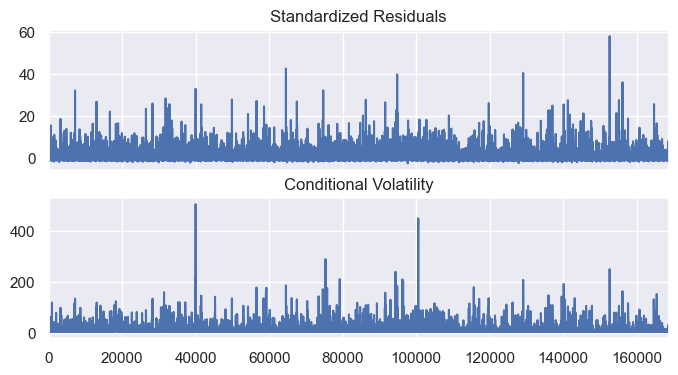

In [20]:
# Plot fitted results
gm_result.plot()
plt.show()

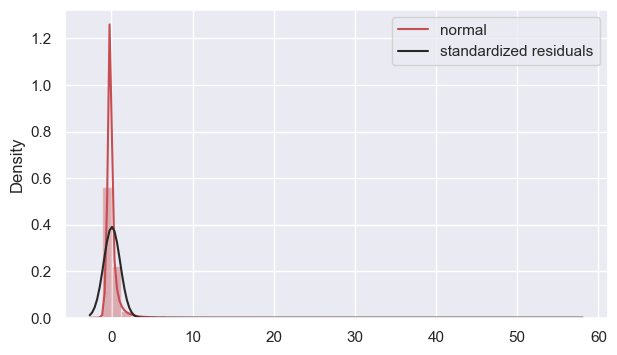

In [21]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

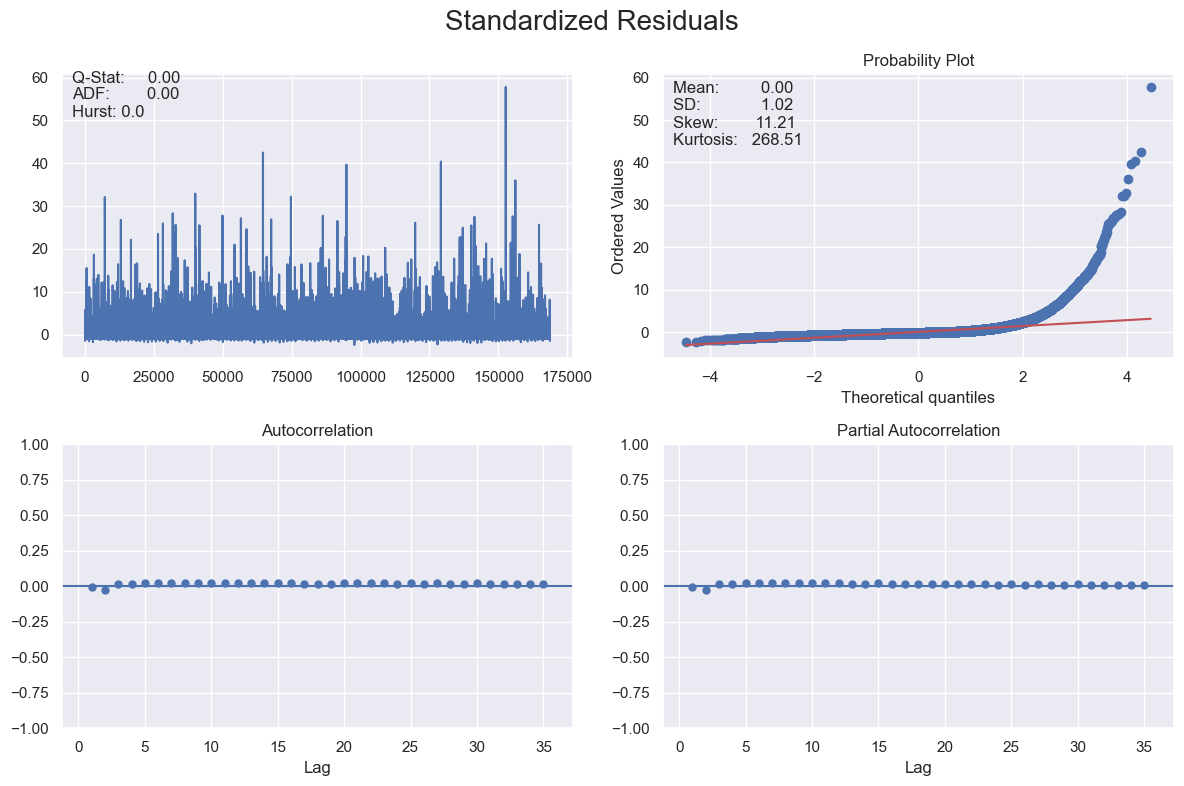

In [22]:
plot_correlogram(gm_std_resid.dropna(), lags=35, title='Standardized Residuals')